# 遞規特徵消除法 (RFE,recursive feature elimination)
RFE方法適用於預測輸出能夠直接解釋特徵重要性的模型，例如決策樹、隨機森林和或是具有係數的線性模型等，RFE方法透過遞迴減少特徵數量，能夠增強模型的泛化能力(Generalization Capability)，也就是讓模型在訓練資料以外的新資料上的預測能力也能夠有穩定的表現，另外能夠減少模型因為多餘的特徵或無相關性特徵而引起的過擬合(Overfitting)問題

## Step 1: 導入所需的套件

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
from imblearn.over_sampling import SMOTE

## 導入特徵選擇RFE
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

## Step 2: 導入數據集

In [4]:
data = pd.read_csv('b_depressed.csv')

## Step 3: 處理缺失值

In [5]:
data.dropna(inplace=True)

## Step 4: 數據整理

In [6]:
data.drop(['Survey_id','Ville_id'],axis=1,inplace=True)

## Step 5: 自訂自變量和應變量

In [7]:
X = data.drop(['depressed'],axis=1)
y = data['depressed']

## Step 6: 使用SMOTE來重組資料

In [8]:
smote_data = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote_data.fit_resample(X, y)

## Step 7: 重新抽樣data組成DataFrame

In [9]:
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data['depressed'] = y_resampled

## Step 8: 數據標準化

In [10]:
scaler = StandardScaler()
columns_to_standardize = ['Age', 'Number_children', 'total_members', 'gained_asset', 
                          'durable_asset', 'save_asset', 'living_expenses','other_expenses',
                         'incoming_agricultural','farm_expenses','lasting_investment','no_lasting_investmen']
resampled_data[columns_to_standardize] = scaler.fit_transform(resampled_data[columns_to_standardize])

## Step 9: 自訂自變量和應變量

In [11]:
X_resamp = resampled_data.drop(['depressed'],axis=1)
y_resamp = resampled_data['depressed']

## Step 10: 切割數據train set與test set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=69)

## Step 11: 建立邏輯迴歸模型，並使用RFE

In [13]:
#建立邏輯迴歸模型
logmodel = LogisticRegression()

In [14]:
# 先預設篩選6個特徵
rfe = RFE(estimator=logmodel, n_features_to_select=6)

In [15]:
# 適配模型
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=6)

In [16]:
# 列出挑選的 6 個變數
print(f"Number of selected features: {rfe.n_features_to_select}\nSelected Features:", 
      [feature for feature, rank in zip(X_resamp.columns.values, rfe.ranking_) if rank == 1])

Number of selected features: 6
Selected Features: ['gained_asset', 'durable_asset', 'living_expenses', 'incoming_agricultural', 'lasting_investment', 'no_lasting_investmen']


In [17]:
# 選擇 RFE 選定的特徵
X_train_rfe = X_train.loc[:, rfe.support_]
X_test_rfe = X_test.loc[:, rfe.support_]

In [18]:
# 初始化和訓練邏輯回歸模型
logmodel_rfe = LogisticRegression()
logmodel_rfe.fit(X_train_rfe, y_train)

LogisticRegression()

## Step 12: 模型表現：計算accuracy及結果顯示 

In [19]:
# 預測
y_pred_train = logmodel_rfe.predict(X_train_rfe)
y_pred_test = logmodel_rfe.predict(X_test_rfe)

In [20]:
#利用metrics評估模型性能指標
acc_test = accuracy_score(y_test,y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test,y_pred_test)
f1_test = f1_score(y_test,y_pred_test)
results_test = pd.DataFrame([['Logistic Regression(test)', acc_test,prec_test,rec_test,f1_test]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])

acc_train = accuracy_score(y_train,y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train,y_pred_train)
f1_train = f1_score(y_train,y_pred_train)
results_train = pd.DataFrame([['Logistic Regression(train)', acc_train,prec_train,rec_train,f1_train]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])

results = pd.concat([results_train,results_test])
print(results)

                        Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression(train)  0.531949   0.528169  0.709779  0.605653
0   Logistic Regression(test)  0.568085   0.530488  0.780269  0.631579


## Step 13: 尋找最佳特徵數量

In [35]:
# 初始化邏輯回歸模型
logmodel = LogisticRegression()

In [36]:
# 初始化變量來存儲結果
scores = []

In [37]:
# 使用for迴圈遍歷1到20個特徵
for n_features in range(1, 21):
    rfe = RFE(estimator=logmodel, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    score = cross_val_score(rfe, X_train, y_train, cv=5, scoring='accuracy').mean()   # K-fold Cross-Validation
    scores.append((n_features, score))

In [42]:
# 找出最好的特徵數量
best_n_features = sorted(scores, key=lambda x: x[1], reverse=True)[0]
print(f"最佳特徵數量: {best_n_features[0]}，交叉驗證準確率: {best_n_features[1]:.4f}")

最佳特徵數量: 20，交叉驗證準確率: 0.5282


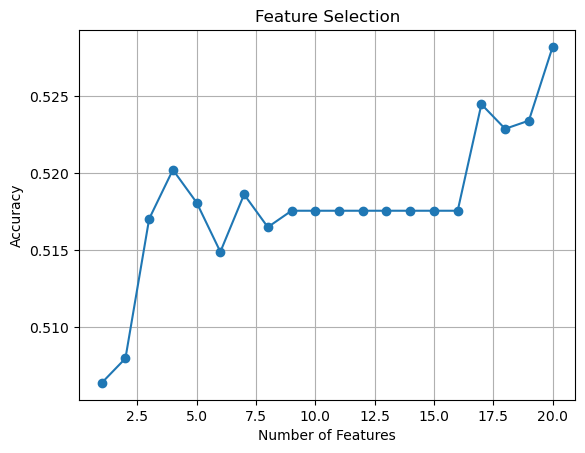

In [39]:
# 畫出特徵數量和準確率的關係
n_features_plot = [x[0] for x in scores]
accuracy_plot = [x[1] for x in scores]

plt.plot(n_features_plot, accuracy_plot, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Feature Selection')
plt.grid(True)
plt.show()

# 小結：加入特徵選擇對正確率影響不大
更換模型->如何選擇最好的演算法?